In [1]:
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
import cv2 as cv
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Proponer una CNN para reconocimiento de acciones
### Obtengo las etiquetas de mis videos que estaran en "y"
 Asi mismo cargare unas covarianzas de videos locales que tengo calculadas, utilizan caracteristicas basicas, por lo que no son computacionalmente pesadas, son covarianzas de 7*7

In [ ]:
binaries_path = sorted(glob("./binarycovs/*.npy"))
binaries = np.array([np.load(path) for path in binaries_path])

In [ ]:
print("Amount of binaries in folder:", binaries.shape)

In [ ]:
y_train=[]
y=[]
x=[]
for i in range(len(binaries_path)):
    x.append(binaries[i])
    y.append(int(binaries_path[i].split('.')[-2][-1]))

In [ ]:
x = np.array(x)
y = np.array(y)

In [ ]:
xi = []
for i in range(len(x)):
    xi.append([])
    for j in range(len(x[i])):
        xi[i].append(x[i][j].flatten())

#### Obtengo un numero elevado de covarianzas por lo que realizo un bag of words obteniendo los 1000 centroides ma representativos(las 1000 covarianzas mas representativas) para poder hacer histogramas para cada videos con estas 1000 palabras

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
total=[]
for i in range(len(binaries)):
    for j in range(len(binaries[i])):
        total.append(binaries[i][j].flatten())

In [ ]:
clus=[]
estimator=KMeans(n_clusters=1000).fit(total)
dictionary=estimator.cluster_centers_
clus.append(dictionary)

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances

In [ ]:
Cluster=[]
for i in range(len(binaries)):
    temp1,temp2=pairwise_distances_argmin_min(xi[i],dictionary,metric='euclidean')
    histogram_vid=plt.hist(temp1,bins=len(dictionary))
    Cluster.append(histogram_vid)


### Aca solo cargo los datos quue ya habia sacado, pero tenia un back up en caso de fallo por falta de ram

Esto se hace con el np.load, antes los habia guardado con np.save

In [ ]:
dataset_train2=np.array(Cluster)

In [3]:
y=np.load('etiquetas.npy')

In [4]:
dataset_train2=np.load('histogramas.npy', allow_pickle=True)

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test= train_test_split(dataset_train2,y, test_size=0.2, shuffle=True)

Creo un modelo que esta basado en VGG16, basicamente, por sus pocas capas lo elegi, y debido a las dimensiones de un histograma fueron editados los kernels a 2*2, fueron extraidas algunas capas, por que se hacia muy pesado para la maquina

In [ ]:
del model_CNN

In [2]:
model_CNN =  keras.models.Sequential()
model_CNN.add(keras.layers.Conv2D(1, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(2, 1000,1)))
model_CNN.add(keras.layers.MaxPooling2D((2, 2), padding='valid'))
model_CNN.add(keras.layers.Conv2D(64, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same'))
#model_CNN.add(keras.layers.MaxPooling2D((2, 2), padding='valid'))
#model_CNN.add(keras.layers.Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same'))
#model_CNN.add(keras.layers.Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_CNN.add(keras.layers.Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same'))
#model_CNN.add(keras.layers.MaxPooling2D((2, 2), padding='valid'))
model_CNN.add(keras.layers.Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_CNN.add(keras.layers.Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_CNN.add(keras.layers.Conv2D(256, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same'))
#model_CNN.add(keras.layers.MaxPooling2D((2, 2), padding='valid'))
model_CNN.add(keras.layers.Flatten())
#model_CNN.add(keras.layers.Dense(25088,activation='relu'))
#model_CNN.add(keras.layers.Dense(1000,activation='relu'))
model_CNN.add(keras.layers.Dense(250,activation='relu'))
model_CNN.add(keras.layers.Dense(6, activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 1000, 1)        5         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 500, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 500, 64)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 500, 128)       32896     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 500, 128)       65664     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 500, 128)       65664     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 500, 256)       1

## Realizo el fit

In [15]:
newx=[]
for i in range(dataset_train2.shape[0]):
    newx.append(np.vstack((dataset_train2[i][0],dataset_train2[i][1][:1000])))
newx=np.array(newx)

In [16]:
newx= newx.reshape([-1, 2, 1000, 1])

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test= train_test_split(newx,y, test_size=0.2, shuffle=True)

In [22]:
model_CNN.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model_CNN.fit(x_train, y_train, batch_size=30, epochs=30, verbose=1,validation_data=(x_test,y_test))

Train on 47 samples, validate on 12 samples
Epoch 1/30
47/47 [==============================] - ETA: 1s - loss: 8.2243 - acc: 0.166 - 4s 81ms/sample - loss: 17.3143 - acc: 0.1277 - val_loss: 12.2903 - val_acc: 0.0833
Epoch 2/30
47/47 [==============================] - ETA: 1s - loss: 7.6280 - acc: 0.233 - 4s 79ms/sample - loss: 16.6506 - acc: 0.2128 - val_loss: 17.8340 - val_acc: 0.0833
Epoch 3/30
47/47 [==============================] - ETA: 1s - loss: 11.3882 - acc: 0.23 - 4s 78ms/sample - loss: 20.9022 - acc: 0.1489 - val_loss: 15.1405 - val_acc: 0.2500
Epoch 4/30
47/47 [==============================] - ETA: 1s - loss: 11.8461 - acc: 0.20 - 3s 74ms/sample - loss: 8.1455 - acc: 0.2553 - val_loss: 2.5709 - val_acc: 0.0000e+00
Epoch 5/30
47/47 [==============================] - ETA: 1s - loss: 1.6870 - acc: 0.333 - 4s 76ms/sample - loss: 2.9602 - acc: 0.2340 - val_loss: 2.0097 - val_acc: 0.0833
Epoch 6/30
47/47 [==============================] - ETA: 1s - loss: 1.4826 - acc: 0.333 - 3

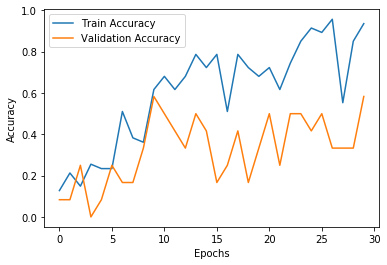

In [23]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()